In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from prophet import Prophet
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
from modules.DataPipeline import (MultiTableTransformer,
                                            Joiner,
                                            SelectiveImputer,
                                            HolydayExtractor)
from modules.ModelClass import ModelClass

In [282]:
sales = pd.read_csv('../data/shop_sales.csv')
prices = pd.read_csv('../data/shop_sales_prices.csv')
calendar = pd.read_csv('../data/shop_sales_dates.csv', index_col='date')

In [283]:
sales_train, sales_test = sales.query('date_id < 1580'), sales.query('date_id >= 1580')
calendar_train, calendar_test = calendar.query('date_id < 1580'), calendar.query('date_id >= 1580')

In [284]:
calendar

,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
date,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1,0,0,0
2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,2,0,0,0
2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,3,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,4,0,1,1
2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-17,11551,Sunday,2,1,2016,NaN,NaN,NaN,NaN,1815,0,0,0
2016-01-18,11551,Monday,3,1,2016,MartinLutherKingDay,National,NaN,NaN,1816,0,0,0
2016-01-19,11551,Tuesday,4,1,2016,NaN,NaN,NaN,NaN,1817,0,0,0


In [285]:
selected_store = 'STORE_1'
mttf = MultiTableTransformer(store_name=selected_store)
imputer_wrapped = SelectiveImputer(imputer = IterativeImputer())
joiner = Joiner()
pipeline = Pipeline([
    ('multi_table_transformer', mttf),
    ('selective_imputer', imputer_wrapped),
    ('joiner', joiner),
    ('holiday_extractor', HolydayExtractor())
])

train_dict = {'sales': sales_train, 'prices': prices, 'calendar': calendar_train}
train_dict = pipeline.fit_transform(train_dict)

In [286]:
train_dict['calendar']

,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1
date,,,,,,,
2011-01-29,11101,noevent,notype,noevent,notype,1,0
2011-01-30,11101,noevent,notype,noevent,notype,2,0
2011-01-31,11101,noevent,notype,noevent,notype,3,0
2011-02-01,11101,noevent,notype,noevent,notype,4,0
2011-02-02,11101,noevent,notype,noevent,notype,5,1
...,...,...,...,...,...,...,...
2015-05-22,11516,noevent,notype,noevent,notype,1575,0
2015-05-23,11517,noevent,notype,noevent,notype,1576,0
2015-05-24,11517,noevent,notype,noevent,notype,1577,0


In [287]:
model = ModelClass(ndim=15, data_pipline=pipeline)

In [288]:
test_dict = {'sales': sales_test, 'prices': prices, 'calendar': calendar_test}
test_dict = model.data_pipeline.transform(test_dict)

In [289]:
test_dict['holidays']

,holiday,ds,lower_window,upper_window
0,NBAFinalsStart,2015-06-04,-3,3
1,NBAFinalsEnd,2015-06-16,-3,3
2,Ramadan starts,2015-06-18,-3,3
3,Father's day,2015-06-21,-3,3
4,IndependenceDay,2015-07-04,-3,3
5,Eid al-Fitr,2015-07-18,-3,3
6,LaborDay,2015-09-07,-3,3
7,EidAlAdha,2015-09-24,-3,3
8,ColumbusDay,2015-10-12,-3,3
9,Halloween,2015-10-31,-3,3


In [290]:
# Не знаю стоило ли делать отдельные методы predict_Q predict_W и predict_M для квартала недели и месяца соответсвенно, просто указываем горизонт и усе
model.fit_prophets(train_dict)
model.fit_catboost(train_dict)
model_preds_prophet = model.predict_prophets(horizon = 90)
model_preds_boost = model.predict_catboost(future_df = test_dict,horizon = 90)

13:50:20 - cmdstanpy - INFO - Chain [1] start processing
13:50:20 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:22 - cmdstanpy - INFO - Chain [1] start processing
13:50:22 - cmdstanpy - INFO - Chain [1] done processing
13:50:22 - cmdstanpy - INFO - Chain [1] start processing
13:50:23 - cmdstanpy - INFO - Chain [1] done processing
13:50:23 - cmdstanpy - INFO - Chain [1] start processing
13:50:23 - cmdstanpy - INFO - Chain [1] done processing
13:50:24 - cmdstanpy - INFO - Chain [1] start processing
13:50:24 - cmdstanpy - INFO - Chain [1] done processing
13:50:25 - cmdstanpy - INFO - Chain [1] start processing
13:50:25 - cmdstanpy - INFO - Chain [1] done processing
13:50:25 - cmdstanpy - INFO - Chain [1] start processing
13:50:26 - cmdstanpy - INFO - Chain [1] done processing
13:50:26 - cmdstanpy - INFO - Chain [1] start processing
13:50:26 - cmdstanpy - INFO - Chain [1]

In [291]:
model.eval_preds(model_preds_prophet[-90:], test_dict['sales'].iloc[:90, :].values, test_dict['prices'].iloc[:90, :].values)

sales_064_hat     1.505016
sales_065_hat     1.386647
sales_090_hat    68.199803
sales_252_hat    11.402210
sales_325_hat     5.825942
sales_339_hat     3.131902
sales_376_hat     1.648613
sales_546_hat    10.073199
sales_547_hat     6.454265
sales_555_hat    10.594483
sales_584_hat     2.271421
sales_586_hat    12.258558
sales_587_hat    12.873556
sales_714_hat    13.017843
sales_727_hat     9.470507
dtype: float64

In [292]:
model.eval_preds(model_preds_boost.iloc[:90, :], test_dict['sales'].iloc[:90, :].values, test_dict['prices'].iloc[:90, :].values)

sales_064_hat     1.502364
sales_065_hat     1.393447
sales_090_hat    49.475452
sales_252_hat    12.230541
sales_325_hat     5.436692
sales_339_hat     3.051883
sales_376_hat     1.594980
sales_546_hat     8.836106
sales_547_hat     5.722880
sales_555_hat    10.117502
sales_584_hat     1.906679
sales_586_hat    12.519026
sales_587_hat    11.690620
sales_714_hat    12.237302
sales_727_hat     8.378240
dtype: float64

In [293]:
model.eval_preds(model_preds_prophet[-30:], test_dict['sales'].iloc[:30, :].values, test_dict['prices'].iloc[:30, :].values)

sales_064_hat     0.790091
sales_065_hat     1.306696
sales_090_hat    55.216362
sales_252_hat    11.798493
sales_325_hat     5.482826
sales_339_hat     3.344988
sales_376_hat     1.394776
sales_546_hat     7.648181
sales_547_hat     5.392138
sales_555_hat    13.151198
sales_584_hat     1.929307
sales_586_hat    19.547354
sales_587_hat    21.423942
sales_714_hat    15.547431
sales_727_hat     4.061668
dtype: float64

In [294]:
model.eval_preds(model_preds_boost.iloc[:30, :], test_dict['sales'].iloc[:30, :].values, test_dict['prices'].iloc[:30, :].values)

sales_064_hat     0.732778
sales_065_hat     1.248593
sales_090_hat    50.693899
sales_252_hat    11.939361
sales_325_hat     4.805922
sales_339_hat     3.165199
sales_376_hat     1.326399
sales_546_hat     6.703943
sales_547_hat     4.872914
sales_555_hat     9.142886
sales_584_hat     1.595319
sales_586_hat    10.099245
sales_587_hat    10.669710
sales_714_hat    11.949168
sales_727_hat     5.742876
dtype: float64

In [295]:
model.eval_preds(model_preds_prophet[-7:], test_dict['sales'].iloc[:7, :].values, test_dict['prices'].iloc[:7, :].values)

sales_064_hat     0.481863
sales_065_hat     0.587920
sales_090_hat    29.215024
sales_252_hat    14.526662
sales_325_hat     3.516391
sales_339_hat     2.512774
sales_376_hat     1.461960
sales_546_hat     5.527933
sales_547_hat     7.488146
sales_555_hat    15.698596
sales_584_hat     2.572310
sales_586_hat    18.648320
sales_587_hat    14.095756
sales_714_hat    14.056402
sales_727_hat     8.740626
dtype: float64

In [296]:
model.eval_preds(model_preds_boost.iloc[:7, :], test_dict['sales'].iloc[:7, :].values, test_dict['prices'].iloc[:7, :].values)

sales_064_hat     0.722728
sales_065_hat     0.501247
sales_090_hat    51.591757
sales_252_hat     5.690289
sales_325_hat     3.823756
sales_339_hat     2.423007
sales_376_hat     1.635279
sales_546_hat     3.667685
sales_547_hat     5.330783
sales_555_hat    10.823207
sales_584_hat     1.698718
sales_586_hat    11.470899
sales_587_hat     8.409684
sales_714_hat    10.655255
sales_727_hat     4.183656
dtype: float64

В краткосрок побеждает Prophet, а вот дальше недели наш стекинг, этого наверное следовало ожидать.
Реализованный класс позволит refit-ить prophet-ы не трогая градиентные бустинги (например раз в 2 недели)
А бустинги можно например раз в квартал, таким образом решим пробелему обучения в онлайне.

В качестве единой метрики могу предложить сумму предиктов (они взвешаны по цене, получается средняя разница в доходе и предсказаниях.
 

In [301]:
prophet_Q = model.eval_preds(model_preds_prophet[-90:], test_dict['sales'].iloc[:90, :].values, test_dict['prices'].iloc[:90, :].values).values.sum()
prophet_M = model.eval_preds(model_preds_prophet[-30:], test_dict['sales'].iloc[:30, :].values, test_dict['prices'].iloc[:30, :].values).values.sum()
prophet_W = model.eval_preds(model_preds_prophet[-7:], test_dict['sales'].iloc[:7, :].values, test_dict['prices'].iloc[:7, :].values).values.sum()

stack_Q = model.eval_preds(model_preds_boost[-90:], test_dict['sales'].iloc[:90, :].values, test_dict['prices'].iloc[:90, :].values).values.sum()
stack_M = model.eval_preds(model_preds_boost[-30:], test_dict['sales'].iloc[:30, :].values, test_dict['prices'].iloc[:30, :].values).values.sum()
stack_W = model.eval_preds(model_preds_boost[-7:], test_dict['sales'].iloc[:7, :].values, test_dict['prices'].iloc[:7, :].values).values.sum()

pd.DataFrame([[prophet_Q, prophet_M, prophet_W], [stack_Q, stack_M, stack_W]], columns=['Q', 'M', 'W'], index = ['prophet', 'stacking']).T

,prophet,stacking
Q,170.113964,146.093713
M,168.035450,150.566326
W,139.130682,147.011272


Ну не так уж и сильно хуже на неделю бустинг, видимо дело все в товаре номер 090, там просадка в ноль перед тестом.

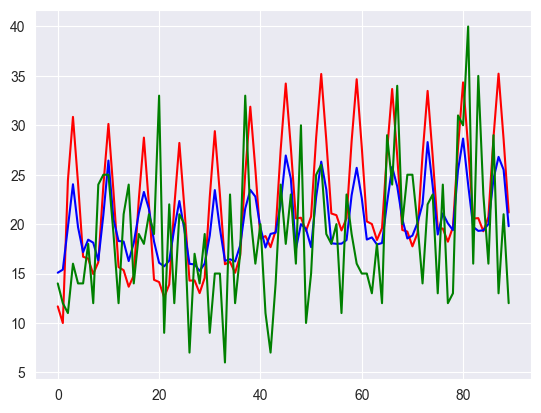

In [252]:
plt.plot(model_preds_prophet['sales_555_hat'][-90:].values[:90], color = 'red')
plt.plot(model_preds_boost['sales_555_hat'].values[:90], color = 'blue')
plt.plot(test_dict['sales']['sales_555'].values[:90], color = 'green')

Сохранять можно вот так

In [253]:
model.save_model(filepath='../models/model.joblib')

In [202]:
model_2 = ModelClass()
model_2.load_model(filepath='../models/model.joblib')

In [173]:
model_2.predict_prophets(horizon = 90).iloc[-90:]

,ds,sales_064_hat,sales_065_hat,sales_090_hat,sales_252_hat,sales_325_hat,sales_339_hat,sales_376_hat,sales_546_hat,sales_547_hat,sales_555_hat,sales_584_hat,sales_586_hat,sales_587_hat,sales_714_hat,sales_727_hat
1579,2015-05-27,0.792753,0.405831,0.000000,13.728467,0.000000,2.636915,0.000000,2.286972,0.000000,11.675324,2.030222,18.951079,21.197434,18.004398,0.404720
1580,2015-05-28,0.011769,0.861334,0.490412,10.790953,0.000000,1.894652,1.859430,3.739914,1.760230,9.995245,0.000000,13.569081,26.779681,20.223705,0.000000
1581,2015-05-29,0.420064,0.198740,9.665721,22.396927,3.543892,2.677994,0.396197,3.237233,7.781563,24.418188,0.760889,34.939727,27.098882,31.969728,0.914537
1582,2015-05-30,0.593728,0.269908,34.075565,26.659003,4.842854,3.104649,0.936726,4.550171,8.509553,30.850691,1.204295,42.548664,30.743906,36.902844,2.188404
1583,2015-05-31,0.409541,0.160460,15.357315,25.000704,3.644369,4.391146,1.006591,5.594151,8.880696,24.152127,0.659686,39.221923,33.956595,31.013837,2.653906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,2015-08-20,0.164126,0.264561,6.053163,22.811966,4.169258,2.763605,0.367187,3.760431,0.820487,20.735162,0.000000,34.278875,28.215454,24.741691,3.755942
1665,2015-08-21,0.307114,0.332991,25.202078,26.221678,5.253863,2.765683,0.237649,3.734024,2.896410,28.746781,0.617477,44.837584,31.187516,32.209336,4.546233
1666,2015-08-22,0.505709,0.420330,50.115201,30.124836,6.547268,3.266823,0.739539,5.161190,2.803146,35.224120,1.136186,52.536522,34.469623,37.564291,5.733961
1667,2015-08-23,0.349344,0.325732,31.813063,28.102158,5.347082,4.641652,0.770778,6.354762,2.461251,28.576173,0.679961,49.300252,37.275847,32.137181,6.089687
